In [7]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy.special import lambertw
import csv
import os
import re
from os import listdir
from os.path import isfile, join

def clean_raw_data(iv_folder, iv_file, vmin, vmax):
    
    """Cleans a txt file with voltage and current data."""
    
    data = np.loadtxt(iv_folder + "/" + iv_file, usecols=(0, 1))
    
    # Sort the data from reverse to forward bias (sort by voltage in ascending order)
    truncated_data = data[(data[:, 0] >= vmin) & (data[:, 0] <= vmax)]
    sorted_data_reverse_to_forward = truncated_data[truncated_data[:, 0].argsort()]
    
    # Separate the re-sorted data into voltage and current arrays
    voltage = sorted_data_reverse_to_forward[:, 0]
    current = sorted_data_reverse_to_forward[:, 1]
    
    return voltage, current
    
def load_result_file(results_folder, results_file):
    """Load a txt file with results from several optimization runs"""
    df = pd.read_csv(results_folder + "/" + results_file, delim_whitespace=True, header=0, dtype=float)
    df.set_index('Run', inplace=True)
    df.index = df.index.astype(int)
    return df   

def calculate_mape(actual, forecast):    
    n = len(actual)
    mape = 100*sum(abs((a - f) / a) for a, f in zip(actual, forecast))/n
    return mape

def lambertw_newton(z, tol=1e-10, max_iter=100):
    w = np.log(z + 1)  # Initial guess
    for i in range(max_iter):
        ew = np.exp(w)
        w_next = w - (w * ew - z) / (ew + w * ew)
        if np.all(np.abs(w_next - w) < tol):
            return w_next
        w = w_next
    return w  # Return the last approximation if convergence criteria are not met

def results(iv_folder, iv_file, results_folder, results_file, temperature_celsius=400, plot=False, save=False):
    area = 3.14*(0.1/2)**2
    voltage, current = clean_raw_data(iv_folder, iv_file, vmin, vmax)
    df = load_result_file(results_folder, results_file)
    best_result = df.loc[df['Objective'].idxmin()]
    charge = 1.60e-19
    boltz = 1.38e-23
    vt = boltz * (temperature_celsius + 273.15) / charge
    objective, i0, n, Rs, Rsh, offset = best_result
    indv = [i0, n, Rs, Rsh, offset]
    print(best_result)
    adjusted_voltage = voltage + indv[4]
    term1 = 1.0 + indv[2] / indv[3]
    term2 = (indv[0] * indv[2]) / (indv[1] * vt * term1)
    term3 = (indv[2] * indv[0] + adjusted_voltage) / (indv[1] * vt * term1)  # V is now an array, so this operation is vectorized
    sim = (indv[1] * vt / indv[2]) * lambertw_newton(term2 * np.exp(term3)) - (indv[0] - adjusted_voltage / indv[3]) / term1
    mape = calculate_mape(sim,current)
    print(f"MAPE: {mape:.2f} %")
    if plot:
        plt.plot(voltage,np.abs(current/area), 'o', color='lightblue', label="Data" )
        plt.plot(voltage,np.abs(sim/area), '-' ,color = '#FF6347', label = "Fit")
        plt.yscale("log")
        plt.xlabel('Voltage (V)')
        plt.ylabel('Current density ($A\,cm^{-2}$)')
        plt.legend(loc='upper left', frameon=False)
        plt.show()

IV curve: iv_curve_400.0_N2_99sccm_H2_1sccm_2024-03-25_14-40-49.txt
Objective   7.675e-02
I0          5.302e-08
n           1.198e+00
Rs          1.995e+01
Rsh         1.450e+05
Offset      3.774e-04
Name: 0, dtype: float64
MAPE: 5.91 %


C:\Users\dfebba\AppData\Local\Temp\2\ipykernel_30464\1557876633.py:37: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(results_folder + "/" + results_file, delim_whitespace=True, header=0, dtype=float)


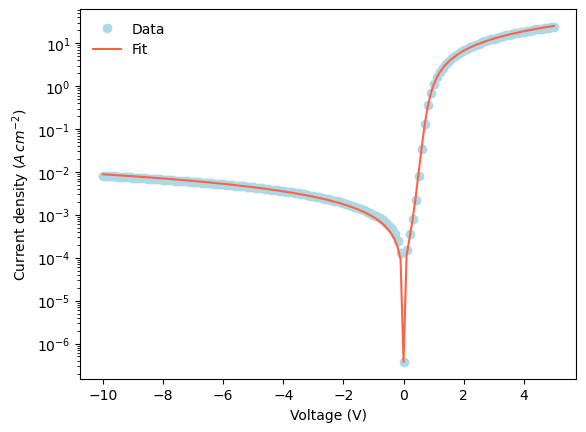

In [4]:
# %matplotlib qt 
pd.set_option('display.float_format', lambda x: '%.3e' % x)
vmin, vmax = -10, 5

iv_folder = "./Data_gas/"
iv_curves = [f for f in listdir(iv_folder) if isfile(join(iv_folder, f))]
iv_filename = iv_curves[6]

results_folder = iv_folder + "/Results"
results_file = "Results_" + iv_filename

print(f"IV curve: {iv_filename}")
results(iv_folder, iv_filename, results_folder, results_file, plot=True)

In [5]:
def load_results(folder_path):
    # Define regex patterns for extracting H2 flow and timestamp
    h2_flow_pattern = r"H2_(\d+)sccm"
    timestamp_pattern = r"(\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2})"
    
    # List to hold each best row DataFrame
    best_rows = []
    
    # Iterate over each file in the specified folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            # Extract H2 flow and timestamp from the file name
            h2_flow = re.search(h2_flow_pattern, filename).group(1)
            timestamp = re.search(timestamp_pattern, filename).group(1)
            
            # Load the file contents into a pandas DataFrame
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path, sep='\s+')
            
            # Find the row with the lowest objective
            best_row = df.loc[[df['Objective'].idxmin()]]
            
            # Add the extracted H2 flow and timestamp as new columns
            best_row['H2_Flow (sccm)'] = int(h2_flow)
            best_row['Timestamp'] = timestamp
            
            # Append the best row DataFrame to the list
            best_rows.append(best_row)
    
    # Concatenate all best row DataFrames from the list into one DataFrame
    best_results_df = pd.concat(best_rows, ignore_index=True)
    
    return best_results_df

folder_path = "./Data_gas/Results"
gas_df = load_results(folder_path)
gas_df

,Run,Objective,I0,n,Rs,Rsh,Offset,H2_Flow (sccm),Timestamp
0,0,7.467e-02,3.836e-08,1.197e+00,1.891e+01,1.460e+05,7.945e-04,0,2024-03-25_14-33-52
1,0,8.034e-02,1.077e-07,1.212e+00,1.965e+01,1.454e+05,1.213e-03,2,2024-03-25_15-40-41
2,0,8.172e-02,1.241e-07,1.219e+00,1.990e+01,1.450e+05,1.473e-03,2,2024-03-25_15-46-08
3,0,8.108e-02,1.374e-07,1.224e+00,1.976e+01,1.444e+05,1.575e-03,2,2024-03-25_15-51-35
4,0,8.228e-02,1.515e-07,1.230e+00,2.018e+01,1.445e+05,1.605e-03,2,2024-03-25_15-57-01
5,0,8.243e-02,1.655e-07,1.235e+00,2.042e+01,1.441e+05,1.652e-03,2,2024-03-25_16-02-28
6,0,7.675e-02,5.302e-08,1.198e+00,1.995e+01,1.450e+05,3.774e-04,1,2024-03-25_14-40-49
7,0,7.794e-02,5.896e-08,1.202e+00,2.035e+01,1.445e+05,5.970e-04,1,2024-03-25_14-46-16
8,0,7.858e-02,5.956e-08,1.196e+00,2.113e+01,1.439e+05,8.261e-04,1,2024-03-25_14-51-43
9,0,7.906e-02,6.340e-08,1.199e+00,2.075e+01,1.437e+05,7.399e-04,1,2024-03-25_14-57-09


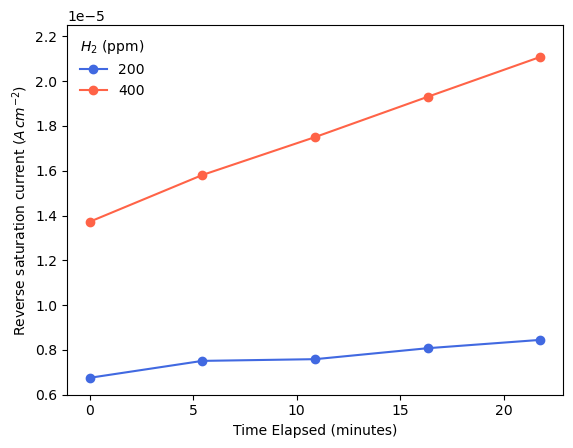

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert 'Timestamp' to datetime just once for the entire DataFrame
gas_df['Timestamp'] = pd.to_datetime(gas_df['Timestamp'], format='%Y-%m-%d_%H-%M-%S')

# Function to filter df by H2 flow, calculate time elapsed, and plot
def plot_i0_vs_time_elapsed_for_flow(df, parameter, flow_value, plot_color):
    area = area = 3.14*(0.1/2)**2
    
    # Convert to ppm (2% H2 in H2/N2 forming gas)
    flow_value_ppm = 1e6*0.02*flow_value/100 

    # Filter the DataFrame for the specified H2 flow
    filtered_df = gas_df[gas_df['H2_Flow (sccm)'] == flow_value].copy()
    
    # Calculate the time elapsed from the first data point
    filtered_df['Time Elapsed'] = (filtered_df['Timestamp'] - filtered_df['Timestamp'].iloc[0]).dt.total_seconds() / 60  # in minutes
    
    # Plotting
    if parameter == "I0":
        plt.plot(filtered_df['Time Elapsed'], filtered_df[parameter]/area, marker='o', linestyle='-', color=plot_color, label=f'{int(flow_value_ppm)}')
    else:
        plt.plot(filtered_df['Time Elapsed'], filtered_df[parameter], marker='o', linestyle='-', color=plot_color, label=f'{int(flow_value_ppm)}')
# Initialize the plot
#plt.figure(figsize=(8, 4))

# Parameter
parameter = "I0"

# Plot for H2 flow of 1 sccm

plot_i0_vs_time_elapsed_for_flow(gas_df, parameter, 1, 'royalblue')

# Plot for H2 flow of 2 sccm
plot_i0_vs_time_elapsed_for_flow(gas_df, parameter, 2, 'tomato')

# Finalizing the plot
#plt.title('I0 vs. Time Elapsed for Different H2 Flows')
plt.xlabel('Time Elapsed (minutes)')
plt.ylabel('Reverse saturation current ($A\,cm^{-2}$)')
plt.ylim(0.6e-5,2.25e-5)
plt.legend(title='$H_{2}$ (ppm)', frameon=False ,loc='upper left')
plt.show()